# Paper
This is reproducing the analysis from Zheng et al (stick paper here) to understand the overall workflow.

## Vascular Dementia vs Control
For identifying genes that were differentially expressed between vascular dementia (VaD) and non-VaD controls, they used pre-existing gene expression dataset from the GEO database, GSE122063. 

In [10]:
# Import libraries used by GEO2R
library(GEOquery)
library(limma)
library(umap)

library(ggplot2)
library(tidyverse)
library(EnhancedVolcano)


This section is pulled from the generated GEO2R code

In [11]:
#this pulls GSE122063 as an ExpressionSet object
gset_122063 <- getGEO("GSE122063", GSEMatrix =TRUE, AnnotGPL=FALSE)

# GPL16699 refers to the platform it was on, according to GEO and this is what GEO2R did so I'm replicating it here
if (length(gset_122063) > 1) idx <- grep("GPL16699", attr(gset_122063, "names")) else idx <- 1
gset_122063 <- gset_122063[[idx]]

# make proper column names to match toptable 
fvarLabels(gset_122063) <- make.names(fvarLabels(gset_122063))

Found 1 file(s)
GSE122063_series_matrix.txt.gz
Using locally cached version: C:\Users\nmshahir\AppData\Local\Temp\RtmpELpwPT/GSE122063_series_matrix.txt.gz
Using locally cached version of GPL16699 found here:
C:\Users\nmshahir\AppData\Local\Temp\RtmpELpwPT/GPL16699.soft.gz 


So GEO2R is a GUI that allows you to directly select samples and then it runs the analysis for you. It performs subsetting like this: 

In [12]:
## group membership for all samples
#gsms <- paste0("000000000000000000000000000000000000XXXXXXXXXXXXXX",
#        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX11111111",
#        "111111111111111111111111111111111111")
#
#sml <- strsplit(gsms, split="")[[1]]
#
## filter out excluded samples (marked as "X")
#sel <- which(sml != "X")
#sml <- sml[sel]
#gset <- gset[ ,sel]

This makes sense if you're using a GUI interface to select your samples, but if you're not we can do it this way. First, lets look at what our ExpressionSet object looks like

In [13]:
gset_122063

ExpressionSet (storageMode: lockedEnvironment)
assayData: 58717 features, 136 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM3454053 GSM3454054 ... GSM3454188 (136 total)
  varLabels: title geo_accession ... tissue:ch1 (47 total)
  varMetadata: labelDescription
featureData
  featureNames: 4 5 ... 62972 (58717 total)
  fvarLabels: ID COL ... SEQUENCE (19 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 30990880 
Annotation: GPL16699 

In particular, we're interested in the phenoData. This contains the names of the sample (sampleNames) as well as the metadata about said samples in varLabels.

In [14]:
varLabels(gset_122063)

 [1] "title"                   "geo_accession"           "status"                  "submission_date"         "last_update_date"       
 [6] "type"                    "channel_count"           "source_name_ch1"         "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "characteristics_ch1.2"   "characteristics_ch1.3"   "characteristics_ch1.4"   "characteristics_ch1.5"  
[16] "characteristics_ch1.6"   "molecule_ch1"            "extract_protocol_ch1"    "label_ch1"               "label_protocol_ch1"     
[21] "taxid_ch1"               "hyb_protocol"            "scan_protocol"           "description"             "description.1"          
[26] "description.2"           "description.3"           "data_processing"         "platform_id"             "contact_name"           
[31] "contact_email"           "contact_department"      "contact_institute"       "contact_address"         "contact_city"           
[36] "contact_state"           "contact_zip/postal_code

This dataset contains samples from controls, patients with VaD, and patients with Alzheimer's disease (AD). This paper only looked at the first two groups, so we want to remove the AD samples from this dataset. More specifcally, we want to create a subset with only controls and VaD samples.

In [15]:
# the disease information the "patient diagnosis:ch1" column
gset_122063$`patient diagnosis:ch1`

  [1] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
  [7] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [13] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [19] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [25] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [31] "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"   "Vascular dementia"  
 [37] "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease" "Alzheimer's disease"
 [43] "Alzheimer's disease" "Alzhe

In [16]:
#So lets subset for only VaD and controls

VaD_v_ctrl <- gset_122063[, gset_122063$`patient diagnosis:ch1` %in% c("Control","Vascular dementia")]
VaD_v_ctrl

ExpressionSet (storageMode: lockedEnvironment)
assayData: 58717 features, 80 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM3454053 GSM3454054 ... GSM3454188 (80 total)
  varLabels: title geo_accession ... tissue:ch1 (47 total)
  varMetadata: labelDescription
featureData
  featureNames: 4 5 ... 62972 (58717 total)
  fvarLabels: ID COL ... SEQUENCE (19 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 30990880 
Annotation: GPL16699 

Now when we look at the patient diagnosis in this subset that we have created, we only have samples labeled as VaD or control.

In [18]:
table(VaD_v_ctrl$`patient diagnosis:ch1`)


          Control Vascular dementia 
               44                36 

In [21]:
VaD_v_ctrl$groups <- ifelse(VaD_v_ctrl$`patient diagnosis:ch1` == "Control","ctrl","VaD") #Assign VaD or control based on diagnosis
VaD_v_ctrl$groups <- factor(VaD_v_ctrl$groups)
table(VaD_v_ctrl$groups)


ctrl  VaD 
  44   36 

In [22]:
VaD_v_ctrl$groups

 [1] VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD 
[28] VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  VaD  ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl
[55] ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl ctrl
Levels: ctrl VaD

In [28]:
design <- model.matrix(~ VaD_v_ctrl$groups)
fit <-lmFit(VaD_v_ctrl, design)
fit <- eBayes(fit)
res_Vad_Ctrl <- topTable(fit, adjust="fdr", sort.by="B", number=250)
full_res_VaD_ctrl <- topTable(fit, adjust="fdr", sort.by="B", number=Inf)
res_Vad_Ctrl <- subset(res_Vad_Ctrl, select=c("ID","adj.P.Val","P.Value","t","B","logFC","SPOT_ID","GB_ACC","SEQUENCE"))
head(res_Vad_Ctrl)

Removing intercept from test coefficients
Removing intercept from test coefficients


         ID    adj.P.Val      P.Value         t        B      logFC       SPOT_ID       GB_ACC
2078   2078 1.837537e-22 3.129481e-27 -16.26668 50.77325 -0.9809206  A_23_P254353    NM_006647
9648   9648 8.306204e-20 2.829233e-24  14.53628 44.30563  0.8083234 A_33_P3378920 NM_001198845
21888 21888 5.255357e-19 2.685095e-23 -13.98455 42.15574 -1.5233886  A_23_P142322    NM_001280
33998 33998 1.177764e-18 8.108094e-23 -13.71695 41.09797 -1.0672392 A_33_P3211864    NR_028407
53404 53404 1.177764e-18 1.002916e-22 -13.66571 40.89432 -2.5096632 A_33_P3349827    NM_006743
59714 59714 1.504970e-18 1.537855e-22 -13.56293 40.48475 -1.9993493  A_23_P148308    NM_006743
                                                          SEQUENCE
2078  ATGGCTGGAGGGCCACTGTGACGGCCGCATCGGCATCTTCCCCAAGTGCTTCGTGGTCCC
9648  ACTGCTCCAGGGTCTCTTTTTGGTCCAAAGGCTAGACCTATAGAGTTGGATCACTTTTTT
21888 TCAAGATCGTCCTTCCAATGGCTGTGTGTTTAAAGATTGTGGGAGCTTCGCTGAACGTTA
33998 TCTCATAATCTTGCATATACCTCTGTAAGTAGTCCCTACATTAAAGTCCCTTGAACCATC


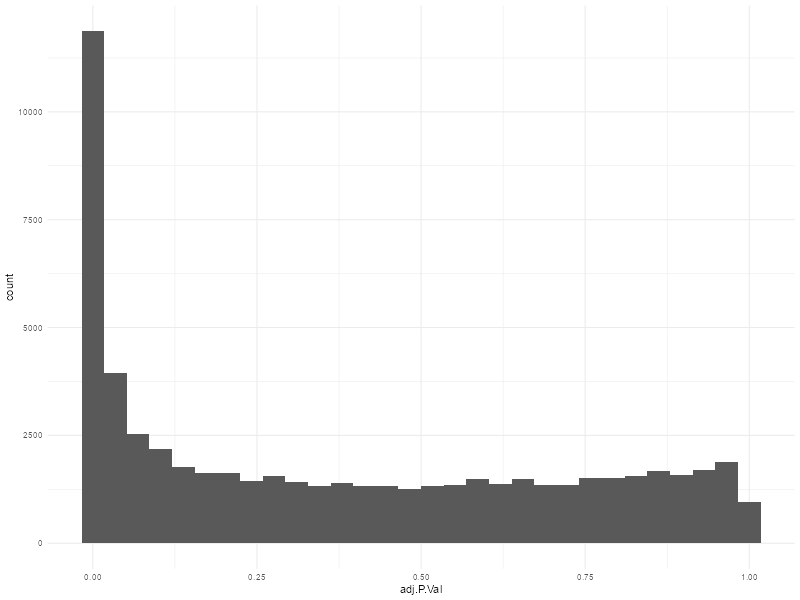

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.

In [31]:
full_res_VaD_ctrl |>
  ggplot(aes(x = adj.P.Val)) +
    geom_histogram() +
    theme_minimal()

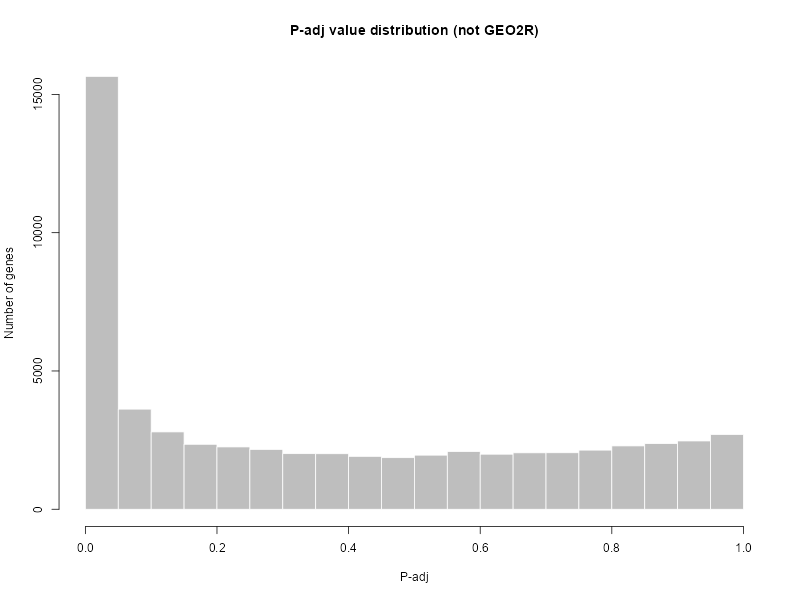

In [29]:
hist(full_res_VaD_ctrl$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution (not GEO2R)")

This paper defined a gene as differentially expressed if it had an adjusted p-value less that 0.05 and the absolute value of logFC greater than 1. So we'll utilize the same cutoffs here.

In [33]:
sig_VaD_ctrl <- full_res_VaD_ctrl  |>
  filter(adj.P.Val < 0.05) |>
  filter(abs(logFC) > 1)

sig_VaD_ctrl

         ID COL ROW           NAME        SPOT_ID CONTROL_TYPE       REFSEQ       GB_ACC LOCUSLINK_ID  GENE_SYMBOL
21888 21888 126 177   A_23_P142322   A_23_P142322        FALSE    NM_001280    NM_001280         1153        CIRBP
33998 33998  89 229  A_33_P3211864  A_33_P3211864        FALSE    NR_028407    NR_028407    100131755       ARMCX4
53404 53404  30 121  A_33_P3349827  A_33_P3349827        FALSE    NM_006743    NM_006743         5935         RBM3
59714 59714  10 294   A_23_P148308   A_23_P148308        FALSE    NM_006743    NM_006743         5935         RBM3
13558 13558 151 110  A_21_P0014071  A_21_P0014071        FALSE    XR_108345    XR_108345           NA LOC100132909
6368   6368 173  58  A_33_P3271387  A_33_P3271387        FALSE    NM_138350    NM_138350        90326        THAP3
59093 59093  12 224  A_21_P0011910  A_21_P0011910        FALSE    NM_012124    NM_012124           NA      CHORDC1
9928   9928 162 154  A_33_P3373765  A_33_P3373765        FALSE    NM_000797    N